### Cell 1：导入库

In [ ]:
import cv2
import dlib
import numpy as np
import os
import time
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### Cell 2：面部关键点检测和分析

In [ ]:
class FaceAnalyzer:
    """面部关键点检测和分析"""
    
    def __init__(self, landmark_model_path=None):
        # 人脸检测器
        self.detector = dlib.get_frontal_face_detector()
        
        # 🎯 关键点检测器 - 支持自定义路径
        if landmark_model_path and os.path.exists(landmark_model_path):
            self.predictor = dlib.shape_predictor(landmark_model_path)
            print(f"✅ 已加载关键点模型: {landmark_model_path}")
        else:
            # 尝试使用默认路径
            default_path = "shape_predictor_68_face_landmarks.dat"
            if os.path.exists(default_path):
                self.predictor = dlib.shape_predictor(default_path)
                print(f"✅ 已加载默认关键点模型: {default_path}")
            else:
                self.predictor = None
                print("⚠️  未找到关键点模型，将仅进行人脸检测")
    
    def detect_face_and_landmarks(self, frame):
        """检测人脸和关键点"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # 🎯 改进的人脸检测 - 多尺度+角度容忍
        faces = self.detector(gray, 1)
        
        if len(faces) == 0:
            # 尝试调整图像
            faces = self.detector(gray, 0)  # 不进行上采样
            if len(faces) == 0:
                # 调整亮度和对比度
                enhanced = cv2.convertScaleAbs(gray, alpha=1.3, beta=40)
                faces = self.detector(enhanced, 1)
        
        if len(faces) == 0:
            return None, None
        
        # 选择最大的人脸
        face = max(faces, key=lambda rect: rect.width() * rect.height())
        
        if self.predictor:
            landmarks = self.predictor(gray, face)
            return face, landmarks
        else:
            return face, None
    
    def extract_fatigue_features(self, landmarks, previous_landmarks=None):
        """提取疲劳相关特征"""
        if landmarks is None:
            return None
        
        features = {}
        
        # 1. 眼睛闭合程度
        left_eye_ratio = self.eye_aspect_ratio([
            landmarks.part(36), landmarks.part(37), landmarks.part(38),
            landmarks.part(39), landmarks.part(40), landmarks.part(41)
        ])
        
        right_eye_ratio = self.eye_aspect_ratio([
            landmarks.part(42), landmarks.part(43), landmarks.part(44),
            landmarks.part(45), landmarks.part(46), landmarks.part(47)
        ])
        
        features['eye_closure'] = (left_eye_ratio + right_eye_ratio) / 2
        
        # 2. 嘴部张开程度 (打哈欠检测)
        mouth_ratio = self.mouth_aspect_ratio([
            landmarks.part(60), landmarks.part(61), landmarks.part(62), landmarks.part(63),
            landmarks.part(64), landmarks.part(65), landmarks.part(66), landmarks.part(67)
        ])
        features['mouth_openness'] = mouth_ratio
        
        # 3. 头部姿态 (简单估计)
        head_pose = self.estimate_head_pose(landmarks)
        features['head_pose'] = head_pose
        
        # 4. 头部运动 (如果提供了前一帧)
        if previous_landmarks:
            head_movement = self.calculate_head_movement(landmarks, previous_landmarks)
            features['head_movement'] = head_movement
        
        return features
    
    def eye_aspect_ratio(self, eye_points):
        """计算眼睛纵横比"""
        # 垂直距离
        A = np.linalg.norm(np.array([eye_points[1].x, eye_points[1].y]) - 
                          np.array([eye_points[5].x, eye_points[5].y]))
        B = np.linalg.norm(np.array([eye_points[2].x, eye_points[2].y]) - 
                          np.array([eye_points[4].x, eye_points[4].y]))
        
        # 水平距离
        C = np.linalg.norm(np.array([eye_points[0].x, eye_points[0].y]) - 
                          np.array([eye_points[3].x, eye_points[3].y]))
        
        ear = (A + B) / (2.0 * C)
        return ear
    
    def mouth_aspect_ratio(self, mouth_points):
        """计算嘴部纵横比"""
        # 垂直距离
        A = np.linalg.norm(np.array([mouth_points[2].x, mouth_points[2].y]) - 
                          np.array([mouth_points[6].x, mouth_points[6].y]))
        
        # 水平距离
        B = np.linalg.norm(np.array([mouth_points[0].x, mouth_points[0].y]) - 
                          np.array([mouth_points[4].x, mouth_points[4].y]))
        
        mar = A / B
        return mar
    
    def estimate_head_pose(self, landmarks):
        """简单估计头部姿态"""
        # 使用鼻子和眼睛的位置关系
        nose_tip = np.array([landmarks.part(30).x, landmarks.part(30).y])
        left_eye_center = np.array([
            (landmarks.part(36).x + landmarks.part(39).x) / 2,
            (landmarks.part(36).y + landmarks.part(39).y) / 2
        ])
        right_eye_center = np.array([
            (landmarks.part(42).x + landmarks.part(45).x) / 2,
            (landmarks.part(42).y + landmarks.part(45).y) / 2
        ])
        
        # 简单的头部倾斜估计
        dx = right_eye_center[0] - left_eye_center[0]
        dy = right_eye_center[1] - left_eye_center[1]
        angle = np.degrees(np.arctan2(dy, dx))
        
        return angle
    
    def calculate_head_movement(self, current_landmarks, previous_landmarks):
        """计算头部运动"""
        # 使用鼻子点的位移
        current_nose = np.array([current_landmarks.part(30).x, current_landmarks.part(30).y])
        previous_nose = np.array([previous_landmarks.part(30).x, previous_landmarks.part(30).y])
        
        movement = np.linalg.norm(current_nose - previous_nose)
        return movement
    
    def draw_landmarks(self, frame, landmarks, color=(0, 255, 0)):
        """在图像上绘制关键点"""
        if landmarks is None:
            return frame
        
        for i in range(68):
            x = landmarks.part(i).x
            y = landmarks.part(i).y
            cv2.circle(frame, (x, y), 2, color, -1)
        
        return frame

### Cell 3：构建实时疲劳检测器

In [ ]:
class RealTimeFatigueDetector:
    def __init__(self, landmark_model_path=None):
        # 🎯 面部分析器 - 规则引擎核心
        self.face_analyzer = FaceAnalyzer(landmark_model_path=landmark_model_path)
        
        # 🎯 状态跟踪
        self.landmark_buffer = deque(maxlen=5)  # 保存最近5帧的关键点
        self.eye_closure_history = deque(maxlen=30)  # 眼睛闭合历史
        self.mouth_openness_history = deque(maxlen=30)  # 嘴部张开历史
        self.state_history = deque(maxlen=10)  # 状态历史
        self.fatigue_scores = deque(maxlen=50)  # 疲劳分数历史
        
        # 🎯 疲劳检测阈值（可调整）
        self.EYE_CLOSURE_THRESHOLD = 0.20  # 眼睛闭合阈值
        self.MOUTH_OPEN_THRESHOLD = 0.55   # 嘴部张开阈值
        self.HEAD_POSE_THRESHOLD = 12      # 头部姿态阈值
        self.FATIGUE_SCORE_THRESHOLD = 55  # 疲劳分数阈值
        
        print("✅ 基于规则的疲劳检测器初始化完成")
    
    def detect_face_robust(self, frame):
        """鲁棒的人脸检测"""
        return self.face_analyzer.detect_face_and_landmarks(frame)
    
    def analyze_fatigue_indicators(self, landmarks, previous_landmarks):
        """分析疲劳指标"""
        if landmarks is None:
            return None
        
        features = self.face_analyzer.extract_fatigue_features(landmarks, previous_landmarks)
        if not features:
            return None
        
        fatigue_score = 0
        
        # 1. 眼睛闭合检测
        eye_closure = features['eye_closure']
        if eye_closure < self.EYE_CLOSURE_THRESHOLD:
            fatigue_score += 40
            self.eye_closure_history.append(1)
        else:
            self.eye_closure_history.append(0)
        
        # 2. 连续闭眼检测
        if len(self.eye_closure_history) >= 10:
            recent_closures = list(self.eye_closure_history)[-10:]
            closure_rate = sum(recent_closures) / len(recent_closures)
            if closure_rate > 0.6:  # 60%的时间闭眼
                fatigue_score += 25
        
        # 3. 打哈欠检测
        mouth_openness = features['mouth_openness']
        if mouth_openness > self.MOUTH_OPEN_THRESHOLD:
            fatigue_score += 35
            self.mouth_openness_history.append(1)
        else:
            self.mouth_openness_history.append(0)
        
        # 4. 连续打哈欠检测
        if len(self.mouth_openness_history) >= 15:
            recent_yawns = list(self.mouth_openness_history)[-15:]
            yawn_rate = sum(recent_yawns) / len(recent_yawns)
            if yawn_rate > 0.4:  # 40%的时间打哈欠
                fatigue_score += 15
        
        # 5. 头部姿态异常
        head_pose = features['head_pose']
        if abs(head_pose) > self.HEAD_POSE_THRESHOLD:
            fatigue_score += 20
        
        # 6. 头部运动检测（如果可用）
        if 'head_movement' in features and features['head_movement'] > 5:
            fatigue_score += 10
        
        # 限制分数在0-100之间
        fatigue_score = min(fatigue_score, 100)
        
        return fatigue_score, features
    
    def predict_fatigue(self, frame):
        """预测疲劳状态"""
        face, landmarks = self.detect_face_robust(frame)
        
        if face is None:
            return 0, 0.0, None, None
        
        # 🎯 获取前一帧关键点用于时序分析
        previous_landmarks = self.landmark_buffer[-1] if self.landmark_buffer else None
        
        # 🎯 使用规则引擎计算疲劳分数
        fatigue_info = self.analyze_fatigue_indicators(landmarks, previous_landmarks)
        
        # 🎯 保存当前关键点
        self.landmark_buffer.append(landmarks)
        
        if fatigue_info:
            fatigue_score, features = fatigue_info
            self.fatigue_scores.append(fatigue_score)
            
            # 使用滑动平均平滑疲劳分数
            if len(self.fatigue_scores) > 0:
                smoothed_score = np.mean(list(self.fatigue_scores))
            else:
                smoothed_score = fatigue_score
            
            # 判断疲劳状态
            if smoothed_score > self.FATIGUE_SCORE_THRESHOLD:
                state = 1  # 疲劳
                confidence = min(smoothed_score / 100.0, 0.95)
            else:
                state = 0  # 清醒
                confidence = 1.0 - (smoothed_score / 100.0)
            
            self.state_history.append((state, confidence))
            return state, confidence, features, face
        
        return 0, 0.5, None, face
    
    def get_smoothed_prediction(self):
        """获取平滑后的预测结果"""
        if not self.state_history:
            return 0, 0.0
        
        states = [state for state, _ in self.state_history]
        confidences = [conf for _, conf in self.state_history]
        
        # 使用多数投票决定状态
        state_counts = {}
        for state in states:
            state_counts[state] = state_counts.get(state, 0) + 1
        
        predicted_state = max(state_counts, key=state_counts.get)
        avg_confidence = np.mean(confidences)
        
        return predicted_state, avg_confidence

### Cell 4：实时检测指标可视化

In [ ]:
class FatigueMonitor:
    def __init__(self, landmark_model_path=None):
        self.detector = RealTimeFatigueDetector(landmark_model_path)
        self.performance_stats = {
            'frame_count': 0,
            'detection_times': deque(maxlen=100),
            'fatigue_frames': 0
        }
    
    def run_detection(self, camera_id=0, show_landmarks=True):
        """运行实时检测"""
        cap = cv2.VideoCapture(camera_id)
        
        if not cap.isOpened():
            print("Error: Could not open camera.")
            return
        
        print("Starting real-time fatigue monitoring...")
        print("Press 'q' to quit")
        print("Press 'r' to reset statistics")
        
        while True:
            start_time = time.time()
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.resize(frame, (640, 480))
            self.performance_stats['frame_count'] += 1
            
            # 进行疲劳检测
            state, confidence, features, face = self.detector.predict_fatigue(frame)
            
            # 更新统计信息
            if state == 1:
                self.performance_stats['fatigue_frames'] += 1
            
            # 获取平滑后的预测结果
            smoothed_state, avg_confidence = self.detector.get_smoothed_prediction()
            
            # 绘制结果
            frame = self.draw_detection_results(frame, smoothed_state, avg_confidence, 
                                              features, face, show_landmarks)
            
            # 计算并显示性能信息
            detection_time = time.time() - start_time
            self.performance_stats['detection_times'].append(detection_time)
            fps = 1.0 / detection_time if detection_time > 0 else 0
            
            self.draw_performance_info(frame, fps)
            
            cv2.imshow('Fatigue Monitoring', frame)
            
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('r'):
                self.reset_statistics()
        
        cap.release()
        cv2.destroyAllWindows()
        self.print_final_statistics()
    
    def draw_detection_results(self, frame, state, confidence, features, face, show_landmarks):
        """在帧上绘制检测结果"""
        label = "FATIGUE" if state == 1 else "ALERT"
        color = (0, 0, 255) if state == 1 else (0, 255, 0)
        
        # 绘制状态和置信度
        cv2.putText(frame, f"State: {label}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        cv2.putText(frame, f"Confidence: {confidence:.2f}", (10, 70), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        # 绘制人脸框
        if face is not None:
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            
            # 绘制关键点
            if show_landmarks and hasattr(self.detector.face_analyzer, 'predictor'):
                landmarks = self.detector.landmark_buffer[-1] if self.detector.landmark_buffer else None
                if landmarks:
                    frame = self.detector.face_analyzer.draw_landmarks(frame, landmarks, color)
        
        # 显示疲劳特征
        if features:
            y_offset = 110
            feature_texts = [
                f"Eye Closure: {features['eye_closure']:.3f}",
                f"Mouth Openness: {features['mouth_openness']:.3f}",
                f"Head Pose: {features['head_pose']:.1f}°"
            ]
            
            if 'head_movement' in features:
                feature_texts.append(f"Head Movement: {features['head_movement']:.2f}")
            
            for text in feature_texts:
                cv2.putText(frame, text, (10, y_offset), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                y_offset += 20
        
        return frame
    
    def draw_performance_info(self, frame, fps):
        """绘制性能信息"""
        fatigue_ratio = (self.performance_stats['fatigue_frames'] / 
                        self.performance_stats['frame_count'])
        
        info_texts = [
            f"FPS: {fps:.1f}",
            f"Frame: {self.performance_stats['frame_count']}",
            f"Fatigue Ratio: {fatigue_ratio:.2f}"
        ]
        
        y_offset = 200
        for text in info_texts:
            cv2.putText(frame, text, (10, y_offset), 
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            y_offset += 20
    
    def reset_statistics(self):
        """重置统计信息"""
        self.performance_stats = {
            'frame_count': 0,
            'detection_times': deque(maxlen=100),
            'fatigue_frames': 0
        }
        self.detector.fatigue_scores.clear()
        self.detector.state_history.clear()
        print("Statistics reset!")
    
    def print_final_statistics(self):
        """打印最终统计信息"""
        print("\n=== Final Statistics ===")
        print(f"Total frames processed: {self.performance_stats['frame_count']}")
        print(f"Fatigue frames: {self.performance_stats['fatigue_frames']}")
        
        if self.performance_stats['frame_count'] > 0:
            fatigue_ratio = (self.performance_stats['fatigue_frames'] / 
                           self.performance_stats['frame_count'])
            print(f"Fatigue ratio: {fatigue_ratio:.3f}")
        
        if self.performance_stats['detection_times']:
            avg_time = np.mean(list(self.performance_stats['detection_times']))
            avg_fps = 1.0 / avg_time if avg_time > 0 else 0
            print(f"Average FPS: {avg_fps:.1f}")

### Cell 5：运行示例

In [ ]:
def main():
    # 初始化监测器
    # 注意：需要下载dlib的68点关键点模型
    landmark_model_path = "F:/M0/Project1_DriverAttention/models/shape_predictor_68_face_landmarks.dat"  # 修改为您的模型路径
    
    monitor = FatigueMonitor(landmark_model_path)
    
    # 开始实时监测
    monitor.run_detection(camera_id=0, show_landmarks=True)

if __name__ == "__main__":
    main()

✅ 已加载关键点模型: F:/M0/Project1_DriverAttention/models/shape_predictor_68_face_landmarks.dat
✅ 基于规则的疲劳检测器初始化完成
Starting real-time fatigue monitoring...
Press 'q' to quit
Press 'r' to reset statistics

=== Final Statistics ===
Total frames processed: 503
Fatigue frames: 187
Fatigue ratio: 0.372
Average FPS: 10.6


### Cell 6：针对单张图片测试（仅返回指标）

✅ 已加载关键点模型: F:/M0/Project1_DriverAttention/models/shape_predictor_68_face_landmarks.dat


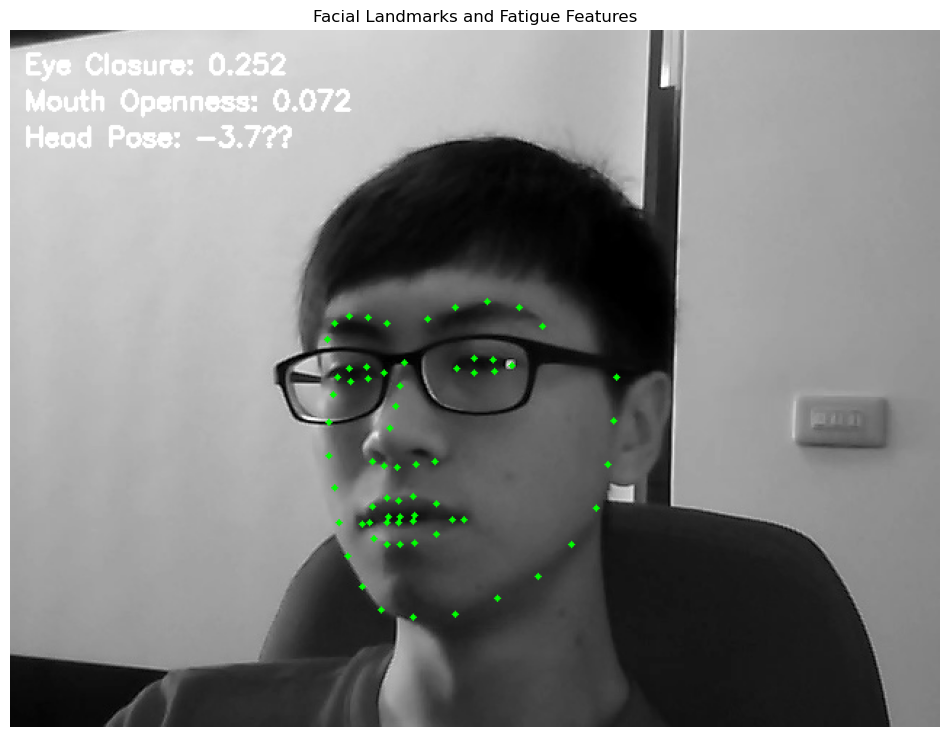

=== 面部疲劳特征分析 ===
眼睛闭合程度: 0.252
嘴部张开程度: 0.072
头部姿态角度: -3.7°


In [ ]:
def visualize_features():
    """可视化特征计算过程"""
    # 加载本地人脸图片
    image_path = "F:/M0/Project1_DriverAttention/data/NTHU-DDD/drowsy/001_glasses_sleepyCombination_607_drowsy.jpg"  # 修改为您的本地图片路径
    
    if not os.path.exists(image_path):
        print(f"⚠️  未找到测试图片: {image_path}")
        print("请将图片路径修改为您的本地人脸图片路径")
        return
    
    # 读取图片
    test_img = cv2.imread(image_path)
    if test_img is None:
        print(f"❌ 无法读取图片: {image_path}")
        return
    
    # 初始化面部分析器
    landmark_model_path = "F:/M0/Project1_DriverAttention/models/shape_predictor_68_face_landmarks.dat"  # 修改为您的模型路径
    analyzer = FaceAnalyzer(landmark_model_path)
    
    # 检测人脸和关键点
    face, landmarks = analyzer.detect_face_and_landmarks(test_img)
    
    if landmarks is None:
        print("❌ 未检测到人脸关键点")
        # 显示原图
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        plt.title("Original Image - No Face Detected")
        plt.axis('off')
        plt.show()
        return
    
    # 绘制关键点
    result_img = analyzer.draw_landmarks(test_img.copy(), landmarks, color=(0, 255, 0))
    
    # 提取特征
    features = analyzer.extract_fatigue_features(landmarks)
    
    # 在图像上添加特征信息
    y_offset = 30
    feature_texts = [
        f"Eye Closure: {features['eye_closure']:.3f}",
        f"Mouth Openness: {features['mouth_openness']:.3f}",
        f"Head Pose: {features['head_pose']:.1f}°"
    ]
    
    for text in feature_texts:
        cv2.putText(result_img, text, (10, y_offset), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        y_offset += 25
    
    # 显示结果
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Facial Landmarks and Fatigue Features")
    plt.axis('off')
    plt.show()
    
    # 打印详细特征信息
    print("=== 面部疲劳特征分析 ===")
    print(f"眼睛闭合程度: {features['eye_closure']:.3f}")
    print(f"嘴部张开程度: {features['mouth_openness']:.3f}")
    print(f"头部姿态角度: {features['head_pose']:.1f}°")

# 运行可视化
visualize_features()